In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os
from scipy.signal import savgol_filter



2024-11-16 00:11:36.061159: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 00:11:36.114385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 00:11:36.936407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def c6_data():
    df = pd.read_csv('Fill-1.csv')
    print(df.shape)

    # 删除重复值
    df.drop_duplicates(inplace=True)
    print(df.shape)

    x = df.iloc[:, :2].values
    y = df.iloc[:, 2].values

    print(x.shape, y.shape)
    
    # 归一化
    scaler_x = StandardScaler()
    scaler_x.fit(x)
    x = scaler_x.transform(x)

    scaler_y = StandardScaler()
    y = y.reshape(-1, 1)  # Reshape y to have one feature
    scaler_y.fit(y)
    y = scaler_y.transform(y)

    # 划分数据集
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=666)

    return x_train, x_test, y_train, y_test, scaler_x, scaler_y

# 保存处理后的数据在csv文件里
x_train, x_test, y_train, y_test, scaler_x, scaler_y = c6_data()

x_train_reshaped = x_train.reshape(x_train.shape[0], x_train.shape[1])
x_test_reshaped = x_test.reshape(x_test.shape[0], x_test.shape[1])

y_train_reshaped = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])

# 将数据转换为DataFrame
df_x_train = pd.DataFrame(x_train_reshaped)
df_x_test = pd.DataFrame(x_test_reshaped)
df_y_train = pd.DataFrame(y_train_reshaped)
df_y_test = pd.DataFrame(y_test_reshaped)

# 保存到CSV文件
df_x_train.to_csv('x_train_tl.csv', index=False)
df_x_test.to_csv('x_test_tl.csv', index=False)
df_y_train.to_csv('y_train_tl.csv', index=False)
df_y_test.to_csv('y_test_tl.csv', index=False)


(169544, 3)
(135550, 3)
(135550, 2) (135550,)


In [3]:
# Define the ANN model
model_ann = Sequential()
model_ann.add(Dense(30, activation='relu', input_dim=x_train.shape[1]))
model_ann.add(Dense(30, activation='relu'))
model_ann.add(Dense(1))
model_ann.compile(optimizer='adam', loss='mse')


2024-11-16 00:11:40.995922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9797 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


In [4]:
model_ann.load_weights('./annmodel/model_ann_weight')


In [5]:
# 解冻更多层
for layer in model_ann.layers[:1]:  # 
    layer.trainable = False
    print(f"Layer {layer.name} is frozen.")
# 添加更多层
model_ann.add(Dense(50, activation='relu'))
model_ann.add(Dense(1))


Layer dense is frozen.


In [6]:
# Compile the model with a lower learning rate
model_ann.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])


In [7]:
# Fine-tune the model with new data
history = model_ann.fit(x_train, y_train, epochs=50, batch_size=200, validation_data=(x_test, y_test))


Epoch 1/50


2024-10-29 05:38:51.035399: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5590ba254400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-29 05:38:51.035421: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-29 05:38:51.039910: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 05:38:51.055524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-29 05:38:51.181743: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


543/543 [==============================] - 3s 2ms/step - loss: 0.6482 - mae: 0.7042 - val_loss: 0.3070 - val_mae: 0.4308
Epoch 2/50
543/543 [==============================] - 1s 2ms/step - loss: 0.2541 - mae: 0.3815 - val_loss: 0.2269 - val_mae: 0.3533
Epoch 3/50
543/543 [==============================] - 1s 2ms/step - loss: 0.2060 - mae: 0.3349 - val_loss: 0.1886 - val_mae: 0.3205
Epoch 4/50
543/543 [==============================] - 1s 2ms/step - loss: 0.1697 - mae: 0.3058 - val_loss: 0.1565 - val_mae: 0.2939
Epoch 5/50
543/543 [==============================] - 1s 2ms/step - loss: 0.1427 - mae: 0.2816 - val_loss: 0.1342 - val_mae: 0.2736
Epoch 6/50
543/543 [==============================] - 1s 2ms/step - loss: 0.1217 - mae: 0.2614 - val_loss: 0.1150 - val_mae: 0.2540
Epoch 7/50
543/543 [==============================] - 1s 2ms/step - loss: 0.1046 - mae: 0.2422 - val_loss: 0.1000 - val_mae: 0.2347
Epoch 8/50
543/543 [==============================] - 1s 2ms/step - loss: 0.0911 - mae:

In [8]:
# Predict using ANN model
y_pred_ann = model_ann.predict(x_test)

# Calculate Mean Squared Error (MSE)
mse_ann = mean_squared_error(y_test, y_pred_ann)

# Calculate Root Mean Squared Error (RMSE)
rmse_ann = np.sqrt(mse_ann)

# Calculate Mean Absolute Error (MAE)
mae_ann = mean_absolute_error(y_test, y_pred_ann)

# Calculate R² Score
r2_ann = r2_score(y_test, y_pred_ann)

print(f"Mean Squared Error (MSE): {mse_ann}")
print(f"Root Mean Squared Error (RMSE): {rmse_ann}")
print(f"Mean Absolute Error (MAE): {mae_ann}")
print(f"R² Score: {r2_ann}")


848/848 [==============================] - 1s 859us/step
Mean Squared Error (MSE): 0.042916870745473026
Root Mean Squared Error (RMSE): 0.2071638741322266
Mean Absolute Error (MAE): 0.1049760951195578
R² Score: 0.9575397107065281


In [9]:
model_ann.save('anntlmodel.h5')

/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Save the fine-tuned model
model_ann.save_weights('./anntlmodel/model_ann_weight_TL')
print("Fine-tuned model saved to disk.")


Fine-tuned model saved to disk.


In [7]:
model_ann.load_weights('./anntlmodel/model_ann_weight_TL')
print("Fine-tuned model loaded from disk.")


Fine-tuned model loaded from disk.


损失图已保存到: tl_ann_fig/loss_plot.png
局部放大损失图已保存到: tl_ann_fig/zoom_loss_plot.png


/tmp/ipykernel_24620/1296409774.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


结合图已保存到: tl_ann_fig/combined_plot_zoomed.png


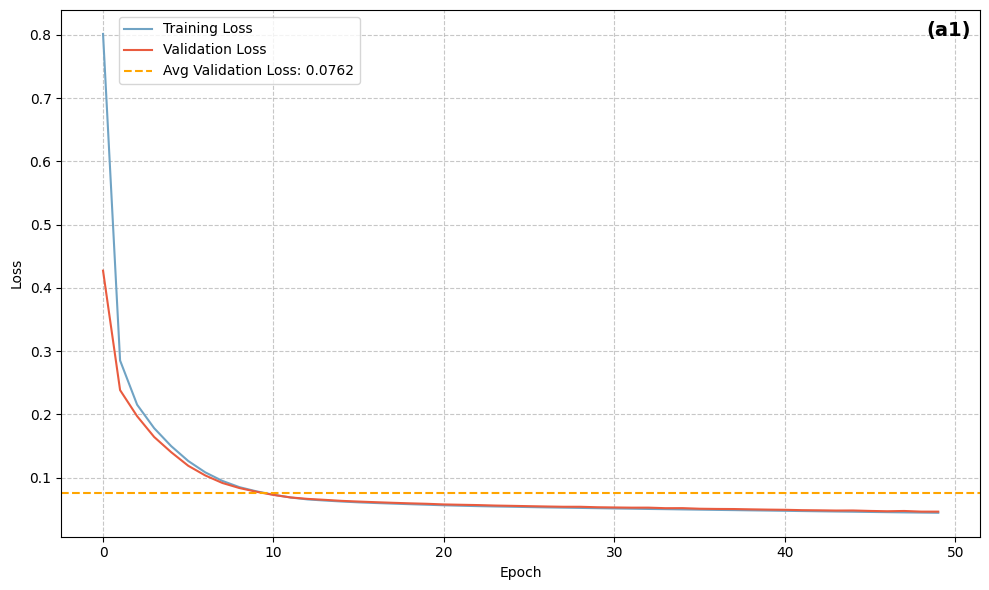

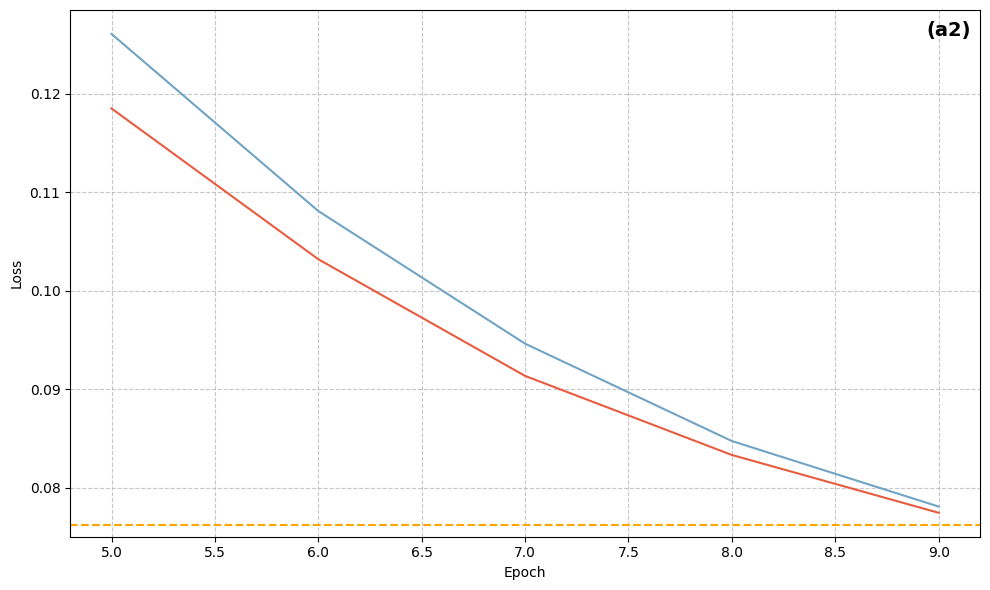

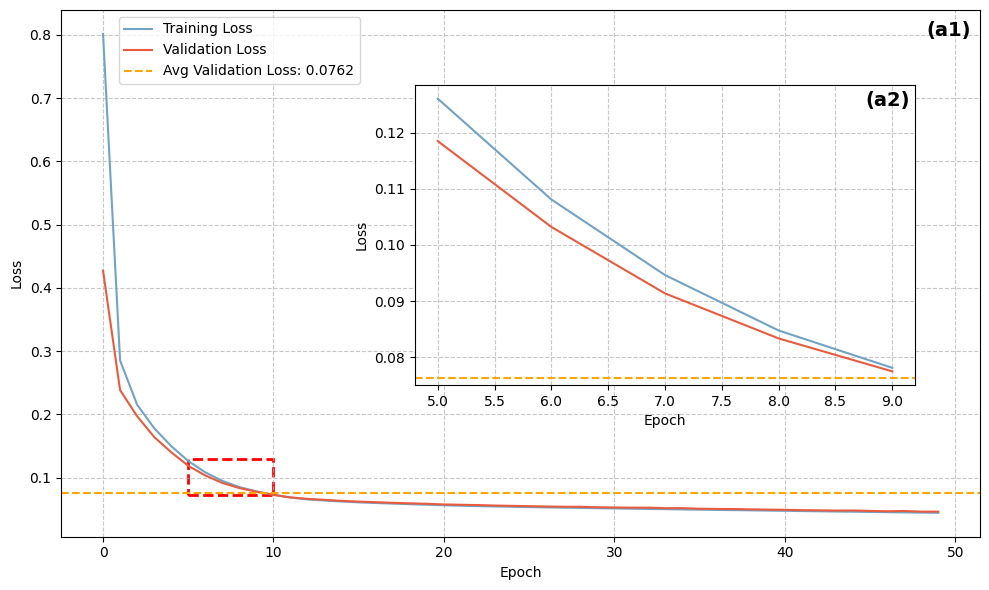

In [52]:
# 创建保存图片的文件夹
folder_name = "tl_ann_fig"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# 自定义放大区间
zoom_epoch_start = 5  # 自定义起始 epoch
zoom_epoch_end = 10   # 自定义结束 epoch

# 自定义虚线框高度和宽度
rect_y_min = 0.073  # 自定义虚线框的下边界
rect_y_max = 0.13  # 自定义虚线框的上边界
rect_x_start = 5    # 自定义虚线框的左边界
rect_x_end = 10     # 自定义虚线框的右边界

    
# 绘制训练和验证损失图
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(history.history['loss'], color='#70A3C4', label='Training Loss')
ax1.plot(history.history['val_loss'], color='#E95B3F', label='Validation Loss')
avg_val_loss = np.mean(history.history['val_loss'])
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(a1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
loss_file_path = os.path.join(folder_name, 'loss_plot.png')
plt.savefig(loss_file_path, dpi=300, bbox_inches='tight')
print(f"损失图已保存到: {loss_file_path}")

# 绘制局部放大图
fig, ax2 = plt.subplots(figsize=(10, 6))

ax2.plot(range(zoom_epoch_start, zoom_epoch_end), history.history['loss'][zoom_epoch_start:zoom_epoch_end], color='#70A3C4', label='Training Loss')
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), history.history['val_loss'][zoom_epoch_start:zoom_epoch_end], color='#E95B3F', label='Validation Loss')
ax2.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.text(0.99, 0.98, '(a2)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
zoom_loss_file_path = os.path.join(folder_name, 'zoom_loss_plot.png')
plt.savefig(zoom_loss_file_path, dpi=300, bbox_inches='tight')
print(f"局部放大损失图已保存到: {zoom_loss_file_path}")

# 绘制结合图，将局部放大图嵌入到主图中
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(history.history['loss'], color='#70A3C4', label='Training Loss')
ax1.plot(history.history['val_loss'], color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(a1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 嵌入放大损失图
inset_ax = fig.add_axes([0.42, 0.35, 0.5, 0.5])  # [left, bottom, width, height]
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), history.history['loss'][zoom_epoch_start:zoom_epoch_end], color='#70A3C4')
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), history.history['val_loss'][zoom_epoch_start:zoom_epoch_end], color='#E95B3F')
inset_ax.axhline(y=avg_val_loss, color='#FFA500', linestyle='--')  # 添加平均值线
inset_ax.set_xlabel('Epoch')
inset_ax.set_ylabel('Loss')
inset_ax.grid(True, linestyle='--', alpha=0.7)
inset_ax.text(0.99, 0.98, '(a2)', transform=inset_ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 添加红色虚线框
rect = plt.Rectangle((rect_x_start, rect_y_min), 
                     rect_x_end - rect_x_start, 
                     rect_y_max - rect_y_min, 
                     edgecolor='red', linestyle='--', linewidth=2, facecolor='none', transform=ax1.transData)
ax1.add_patch(rect)

# 添加标注和链接
# ax1.annotate('', xy=(0.6, 0.45), xycoords='axes fraction', xytext=(0.45, 0.25), textcoords='axes fraction',
#              arrowprops=dict(facecolor='black', shrink=0.05, width=2))

plt.tight_layout()
combined_file_path = os.path.join(folder_name, 'combined_plot_zoomed.png')
plt.savefig(combined_file_path, dpi=300, bbox_inches='tight')
print(f"结合图已保存到: {combined_file_path}")

# 显示图表
plt.show()

Fine-tuned model loaded from disk.
825/825 [==============================] - 1s 810us/step


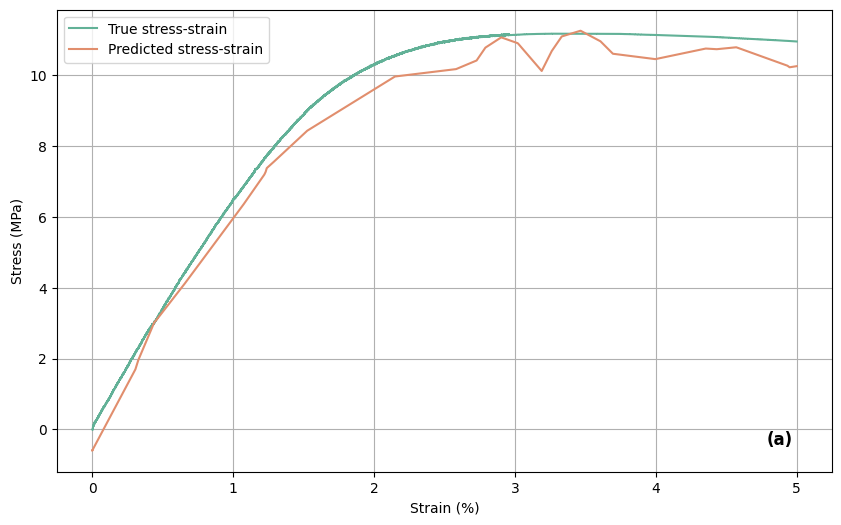

应力-应变曲线已保存并显示: tl_ann_fig/prediction/stress_strain_curve_fill_7.png


In [9]:

# 确保保存图片的文件夹存在
folder_path = os.path.join('tl_ann_fig', 'prediction')
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# 加载迁移学习后的模型权重
model_ann.load_weights('./anntlmodel/model_ann_weight_TL')
print("Fine-tuned model loaded from disk.")

# 读取新数据
file_name = '60-p.csv'
df_new_data = pd.read_csv(file_name)

# 提取特征和真实值
strain = df_new_data.iloc[:, 1].values  # 假设第二列是应变值
stress_true = df_new_data.iloc[:, 2].values  # 第三列为真实应力值

# 对新数据进行归一化处理
x_new = df_new_data.iloc[:, :2].values  # 取前两列作为输入特征
x_new_scaled = scaler_x.transform(x_new)

# 进行预测
stress_pred_scaled = model_ann.predict(x_new_scaled)

# 将预测值逆归一化，恢复到原始尺度
stress_pred = scaler_y.inverse_transform(stress_pred_scaled.reshape(-1, 1)).flatten()


# 确保预测值和实际值的长度相同
min_length = min(len(strain), len(stress_pred))
strain_truncated = strain[:min_length]
stress_true_truncated = stress_true[:min_length]
stress_pred_truncated = stress_pred[:min_length]

# 使用特定的应变阈值
strain_threshold = 5  # 根据之前的阈值设置
valid_indices = strain_truncated < strain_threshold
strain_truncated = strain_truncated[valid_indices]
stress_true_truncated = stress_true_truncated[valid_indices]
stress_pred_truncated = stress_pred_truncated[valid_indices]

# 对预测值进行平滑处理
stress_pred_smoothed = savgol_filter(stress_pred_truncated, window_length=331, polyorder=1)


# 绘制预测结果与真实值的对比图
plt.figure(figsize=(10, 6))
plt.plot(strain_truncated, stress_true_truncated, label='True stress-strain', color='#62B197')
plt.plot(strain_truncated, stress_pred_truncated, label='Predicted stress-strain', color='#E18E6D')
plt.xlabel('Strain (%)')
plt.ylabel('Stress (MPa)')
plt.legend()
# plt.title('True vs Predicted Stress-Strain Curve')
plt.grid(True)

# 在右下角添加文本 (b1)
plt.text(0.95, 0.05, '(a)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='bottom')

# 保存图像
save_path = os.path.join(folder_path, 'stress_strain_curve_fill_7.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"应力-应变曲线已保存并显示: {save_path}")

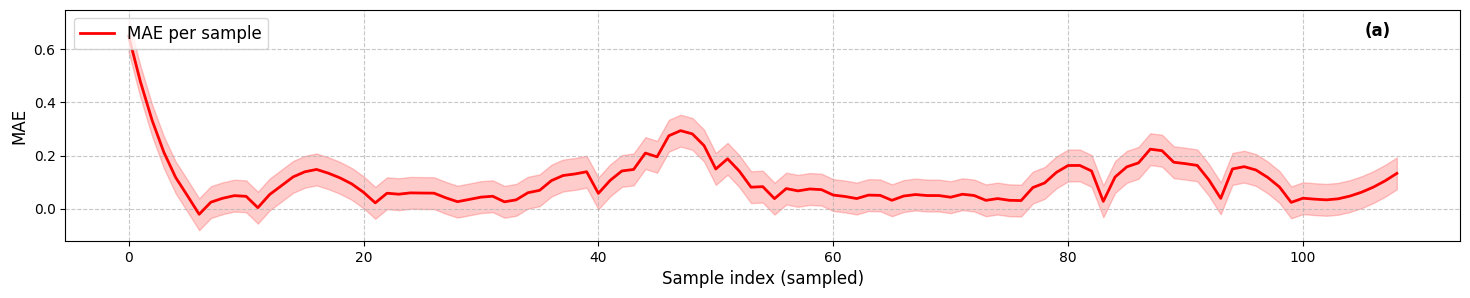

MAE per sample plot saved and displayed: ./tl_ann_fig/mae_per_sample.png


In [19]:
from scipy.signal import savgol_filter

# 计算每个样本的 MAE
mae_per_sample = np.abs(y_test - y_pred_ann).flatten()

# 采样数据以减少密度（例如，每隔250个点取一个）
sampling_rate = 250
mae_sampled = mae_per_sample[::sampling_rate]

# 确保 window_length 小于或等于数据长度，并且是奇数
window_length = min(11, len(mae_sampled))
if window_length % 2 == 0:
    window_length -= 1

# 如果 window_length 仍然大于数据长度，调整为数据长度的最大奇数
if window_length < 3:
    window_length = 3

# 平滑曲线（使用 Savitzky-Golay 滤波器）
polyorder = 2  # 确保 polyorder 小于 window_length
mae_smoothed = savgol_filter(mae_sampled, window_length, polyorder)

# 绘制 MAE 随时间变化的图
plt.figure(figsize=(18, 3))
plt.plot(mae_smoothed, label='MAE per sample', color='red', linewidth=2)

# 添加跟随曲线变化的窄色条
offset = 0.06  # 设置窄色条的宽度
plt.fill_between(range(len(mae_smoothed)), mae_smoothed - offset, mae_smoothed + offset, color='red', alpha=0.2)

# 设置图例位置为左上角
plt.legend(loc='upper left', fontsize=12)

# 在右上角添加文本 (a)
plt.text(0.95, 0.95, '(a)', fontsize=12, fontweight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.xlabel('Sample index (sampled)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 保存图像
mae_timestep_path = './tl_ann_fig/mae_per_sample.png'
plt.savefig(mae_timestep_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"MAE per sample plot saved and displayed: {mae_timestep_path}")